# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable" / "1y"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'jitter'

In [5]:
# Load real time series
data_train_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_1y.csv')
data_train_real_numpy = dc(data_train_real_df).to_numpy()

data_test_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_3mo.csv')
data_test_real_numpy = dc(data_test_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_lstm_autoencoder_unscaled_15.csv', shape=(28478, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_lstm_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'jittered_01.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_train_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal train data:\n')
print(data_train_real_df.describe())

print('\n\nreal test data:\n')
print(data_test_real_df.describe())



 syn data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.000000  8759.000000
mean      3242.999554   282.195389     0.121158     0.000483    44.847967
std       1954.971277    12.166623     0.900317     0.006140    38.883359
min          0.000000   242.975253     0.000000     0.000000     0.000000
25%       1266.647637   273.603328     0.000000     0.000000     2.874516
50%       3413.554372   283.584600     0.003998     0.000016    40.097688
75%       4869.564219   292.030356     0.069818     0.000425    87.130849
max       7355.044574   309.647461    42.019570     0.250347   104.283866


real train data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.000000  8759.000000
mean      3244.668912   282.208136     0.086792     0.000233    44.397306
std       1946.247953    12.114907     0.901360     0.006145    39.195308
min 

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 12,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 1,
    "num_epochs": 1,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(
    data_train_real=data_train_real_numpy, 
    data_test_real=data_test_real_numpy,
    data_syn=data_syn_numpy, 
    hyperparameters=hyperparameters, 
    include_baseline=True, 
    verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  12
num_layers :  1
bidirectional :  True
num_evaluation_runs :  1
num_epochs :  1
device :  cpu
Synthetic Data is sequential: False
Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/1 [00:00<?, ?it/s]/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_evaluation/predictive/predictive_evaluation.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch: 1
Train Loss: 0.1974761337279784 // Train Acc: 0.011405109489051095
Val Loss: 0.13571398281098535 // Val Acc: 0.0
**************************************************
Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)
Shape of the data after splitting into sequences: (8748, 12, 5)


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 1
Train Loss: 0.11064361883795153 // Train Acc: 0.014269406392694063
Val Loss: 0.0717398231679743 // Val Acc: 0.0
**************************************************
Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)
Shape of the data after splitting into sequences: (8748, 12, 5)


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 1
Train Loss: 0.17201061460049186 // Train Acc: 0.014269406392694063
Val Loss: 0.11079389236190103 // Val Acc: 0.0
**************************************************
Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)
Shape of the data after splitting into sequences: (8748, 12, 5)


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

Epoch: 1
Train Loss: 0.12001206337302324 // Train Acc: 0.005712979890310786
Val Loss: 0.07781609071089941 // Val Acc: 0.0
**************************************************


NameError: name 'jitter_factor' is not defined

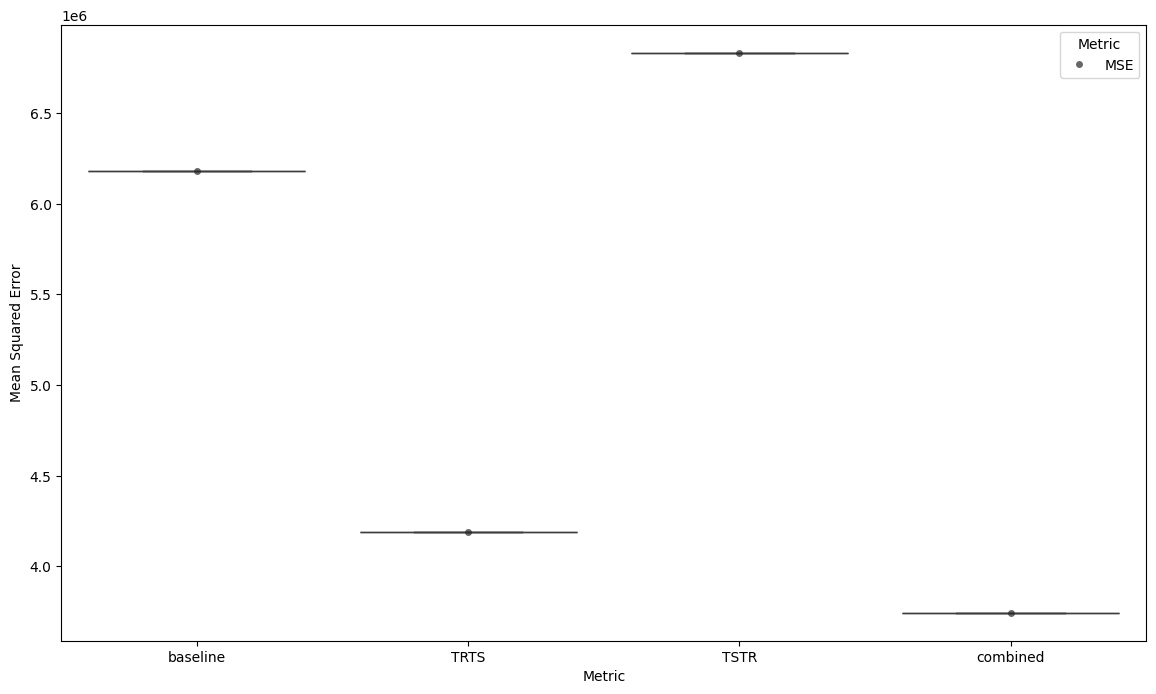

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [ ]:
0.2*1e06

200000.0